# 1. Configuración del Entorno y Carga de Datos
Explicación: En este primer paso, cargaremos las librerías fundamentales del ecosistema tidyverse (que incluye ggplot2 para gráficos y dplyr para manipulación). También cargamos el dataset y echamos un primer vistazo crudo.

In [2]:
# Instalar y cargar librerías necesarias (si no están instaladas)
if(!require(tidyverse)) install.packages("tidyverse")
if(!require(ggthemes)) install.packages("ggthemes") # Para diseños bonitos
if(!require(corrplot)) install.packages("corrplot") # Para correlaciones

library(tidyverse)
library(ggthemes)
library(corrplot)

# Cargar el dataset
# Asegúrate de que el nombre del archivo coincida con el que subiste
df <- read.csv("used_cars_data.csv", stringsAsFactors = FALSE)

# Vista preliminar
head(df)

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>
1,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5,,1.75
2,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5,,12.50
3,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5,8.61 Lakh,4.50
4,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7,,6.00
5,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5,,17.74
6,5,Hyundai EON LPG Era Plus Option,Hyderabad,2012,75000,LPG,Manual,First,21.1 km/kg,814 CC,55.2 bhp,5,,2.35


#Resultado de la salida:
Verás que tenemos columnas como Mileage, Engine y Power que son de tipo "character" (texto) porque incluyen unidades (ej: "26.6 km/kg"), lo cual es un problema para calcular medias o graficar. También notarás que la columna New_Price tiene muchos valores vacíos.

# 2. Limpieza de Datos (Data Cleaning)
Explicación del bloque: Este es el paso más importante. Vamos a realizar las siguientes acciones:

Eliminar New_Price: Esta columna tiene demasiados datos faltantes y no aporta valor.

Eliminar filas sin Price: Si queremos predecir el precio, no nos sirven los coches que no lo tienen.

Conversión de unidades: Quitaremos los textos "kmpl", "CC", "bhp" de las columnas numéricas para convertirlas en números reales.

Gestión de nulos: Eliminaremos las filas que queden con datos corruptos (NA).

In [11]:
# Cargar librerías necesarias
library(dplyr)
library(stringr)

In [12]:
cat("### PASO 1: Filtrado Inicial y Descarte de NAs en Price ###\n")

df <- df %>%
  # 1.1 Eliminar la variable 'New_Price'
  select(-New_Price) %>%

  # 1.2 Eliminar filas donde no se conoce el 'Price' (variable objetivo).
  filter(!is.na(Price))

cat("--> Columna 'New_Price' eliminada. Filas sin 'Price' descartadas.\n")
cat("Dimensiones Actuales de df (Filas x Columnas):", dim(df), "\n")
cat("-----------------------------------------------------------\n")
print(head(df, 3) %>% select(S.No., Price, Mileage, Fuel_Type))

### PASO 1: Filtrado Inicial y Descarte de NAs en Price ###
--> Columna 'New_Price' eliminada. Filas sin 'Price' descartadas.
Dimensiones Actuales de df (Filas x Columnas): 6019 13 
-----------------------------------------------------------
  S.No. Price    Mileage Fuel_Type
1     0  1.75 26.6 km/kg       CNG
2     1 12.50 19.67 kmpl    Diesel
3     2  4.50  18.2 kmpl    Petrol


In [13]:
cat("\n### PASO 2: Limpieza de Unidades (Mileage, Engine, Power) ###\n")

df <- df %>%
  mutate(
    # str_extract extrae la secuencia de números y puntos; as.numeric convierte el tipo.
    Mileage = as.numeric(str_extract(Mileage, "[0-9.]+")),
    Engine  = as.numeric(str_extract(Engine, "[0-9.]+")),
    Power   = as.numeric(str_extract(Power, "[0-9.]+"))
  )

cat("--> Columnas 'Mileage', 'Engine', 'Power' son ahora numéricas (dbl).\n")
cat("Se introdujeron NAs donde el valor original no era válido (ej: '-').\n")
cat("-----------------------------------------------------------\n")
print(head(df, 3) %>% select(Mileage, Engine, Power))


### PASO 2: Limpieza de Unidades (Mileage, Engine, Power) ###
--> Columnas 'Mileage', 'Engine', 'Power' son ahora numéricas (dbl).
Se introdujeron NAs donde el valor original no era válido (ej: '-').
-----------------------------------------------------------
  Mileage Engine  Power
1   26.60    998  58.16
2   19.67   1582 126.20
3   18.20   1199  88.70


In [14]:
cat("\n### PASO 3: Conversión a Factor y Eliminación de NAs Residuales ###\n")

df <- df %>%
  mutate(
    # Convertir variables discretas a tipo Factor
    Fuel_Type    = as.factor(Fuel_Type),
    Transmission = as.factor(Transmission),
    Owner_Type   = as.factor(Owner_Type),
    Location     = as.factor(Location)
  ) %>%

  # Eliminar cualquier fila que aún contenga NA en las variables clave.
  na.omit()

cat("--> NAs residuales eliminados. Tipos categóricos convertidos a Factor.\n")
cat("Dimensiones Actuales de df (Filas x Columnas):", dim(df), "\n")
cat("-----------------------------------------------------------\n")
print(head(df, 3) %>% select(Fuel_Type, Transmission, Owner_Type))


### PASO 3: Conversión a Factor y Eliminación de NAs Residuales ###
--> NAs residuales eliminados. Tipos categóricos convertidos a Factor.
Dimensiones Actuales de df (Filas x Columnas): 5872 13 
-----------------------------------------------------------
  Fuel_Type Transmission Owner_Type
1       CNG       Manual      First
2    Diesel       Manual      First
3    Petrol       Manual      First


In [15]:
cat("\n### PASO 4: Creación de ID y Asignación Final a df_clean ###\n")

df_clean <- df %>%
  # 5.1 Crear el nuevo ID consecutivo
  mutate(ID = row_number()) %>%
  # 5.2 Eliminar la columna de índice original (S.No.)
  select(-S.No.) %>%
  # 5.3 Mover el nuevo 'ID' a la primera columna.
  select(ID, everything())

cat("--> ID secuencial creado, S.No. eliminado. El dataframe limpio final es df_clean.\n")
cat("-----------------------------------------------------------\n")

# Mostramos el resultado final (df_clean)
cat("Dataframe Limpio y Definitivo (df_clean):\n")
print(head(df_clean, 5))


### PASO 4: Creación de ID y Asignación Final a df_clean ###
--> ID secuencial creado, S.No. eliminado. El dataframe limpio final es df_clean.
-----------------------------------------------------------
Dataframe Limpio y Definitivo (df_clean):
  ID                             Name   Location Year Kilometers_Driven
1  1           Maruti Wagon R LXI CNG     Mumbai 2010             72000
2  2 Hyundai Creta 1.6 CRDi SX Option       Pune 2015             41000
3  3                     Honda Jazz V    Chennai 2011             46000
4  4                Maruti Ertiga VDI    Chennai 2012             87000
5  5  Audi A4 New 2.0 TDI Multitronic Coimbatore 2013             40670
  Fuel_Type Transmission Owner_Type Mileage Engine  Power Seats Price
1       CNG       Manual      First   26.60    998  58.16     5  1.75
2    Diesel       Manual      First   19.67   1582 126.20     5 12.50
3    Petrol       Manual      First   18.20   1199  88.70     5  4.50
4    Diesel       Manual      First   20.7

# Resultado de la salida:
Al ejecutar el código, la salida será mucho más detallada y mostrará lo siguiente:

Dimensiones: Confirmación del número exacto de filas eliminadas.

summary(df_clean):

Para las columnas numéricas (Price, Engine, Power), confirmará la Media, Mediana, y rangos sin ningún valor NA.

Para las columnas categóricas (Fuel_Type, Transmission), mostrará la frecuencia de los niveles (ej., cuántos son Diesel, cuántos Manual), lo cual es una excelente vista previa del EDA.

df_clean %>% head(10): Esta es la parte más importante. Verás una tabla con TODAS las columnas (incluyendo ID, Name, Location, etc.) para las primeras 10 filas, demostrando visualmente que:

La columna ID es consecutiva (1, 2, 3...).

Las unidades (kmpl, bhp, CC) han desaparecido de las columnas y son números limpios.

La columna New_Price y S.No. ya no existen.



# 3. EDA: Análisis Exploratorio de Datos Detallado
Explicación del bloque: Ya con el dataframe limpio (df_clean listo), exploramos estadísticamente las distribuciones y frecuencias de las variables más importantes. Este análisis nos permite entender la demografía del dataset y la relación entre las características y la variable objetivo (Price), antes de pasar a la visualización

In [16]:
# Resumen de variables numéricas clave
cat("### Resumen Estadístico Numérico Clave (Variables predictoras) ###\n")
df_clean %>%
  select(Year, Kilometers_Driven, Mileage, Engine, Power, Price) %>%
  summary()

### Resumen Estadístico Numérico Clave (Variables predictoras) ###


      Year      Kilometers_Driven    Mileage          Engine    
 Min.   :1998   Min.   :    171   Min.   : 0.00   Min.   : 624  
 1st Qu.:2012   1st Qu.:  33422   1st Qu.:15.26   1st Qu.:1198  
 Median :2014   Median :  52609   Median :18.20   Median :1496  
 Mean   :2013   Mean   :  58317   Mean   :18.28   Mean   :1626  
 3rd Qu.:2016   3rd Qu.:  72403   3rd Qu.:21.10   3rd Qu.:1991  
 Max.   :2019   Max.   :6500000   Max.   :33.54   Max.   :5998  
     Power           Price        
 Min.   : 34.2   Min.   :  0.440  
 1st Qu.: 75.0   1st Qu.:  3.518  
 Median : 97.7   Median :  5.750  
 Mean   :113.3   Mean   :  9.604  
 3rd Qu.:138.1   3rd Qu.: 10.000  
 Max.   :560.0   Max.   :160.000  

In [17]:
# Análisis de Correlación: ¿Qué variables influyen más en el precio?
# Muestra el coeficiente de correlación de Pearson de Price con el resto.
cor_precio <- cor(df_clean %>% select(Year, Kilometers_Driven, Mileage, Engine, Power, Price))
cat("\nCorrelación de 'Price' con otras variables numéricas:\n")
# Imprimimos solo la fila de correlaciones con 'Price'
print(cor_precio["Price", ])


Correlación de 'Price' con otras variables numéricas:
             Year Kilometers_Driven           Mileage            Engine 
      0.299475450      -0.008248536      -0.341651955       0.658047226 
            Power             Price 
      0.772842899       1.000000000 


In [18]:


# Conteo y Distribución de variables categóricas
cat("\n### Conteo de Variables Categóricas (Frecuencias) ###\n")
cat("\n1. Tipos de Combustible:\n")
print(table(df_clean$Fuel_Type))

cat("\n2. Tipos de Transmisión:\n")
print(table(df_clean$Transmission))

cat("\n3. Antigüedad del Propietario (Owner_Type):\n")
print(table(df_clean$Owner_Type))

cat("\n4. Conteo de Coches por Sede (Top 5 Locations):\n")
df_clean %>%
  count(Location) %>%
  arrange(desc(n)) %>%
  head(5) %>%
  print()


### Conteo de Variables Categóricas (Frecuencias) ###

1. Tipos de Combustible:

     CNG   Diesel Electric      LPG   Petrol 
      55     3152        0       10     2655 

2. Tipos de Transmisión:

Automatic    Manual 
     1702      4170 

3. Antigüedad del Propietario (Owner_Type):

         First Fourth & Above         Second          Third 
          4839              7            925            101 

4. Conteo de Coches por Sede (Top 5 Locations):
    Location   n
1     Mumbai 775
2  Hyderabad 718
3      Kochi 645
4 Coimbatore 629
5       Pune 594


# 4. Visualización de Datos (Gráficas)
Utilizando las conclusiones anteriores, generamos 5 gráficos que resumen la información más importante para la exposición.

# Gráfica 1:
### Distribución del Precio (Histograma Logarítmico)
Explicación: Muestra la forma de la variable objetivo. La escala logarítmica maneja la gran diferencia entre precios bajos y altos.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


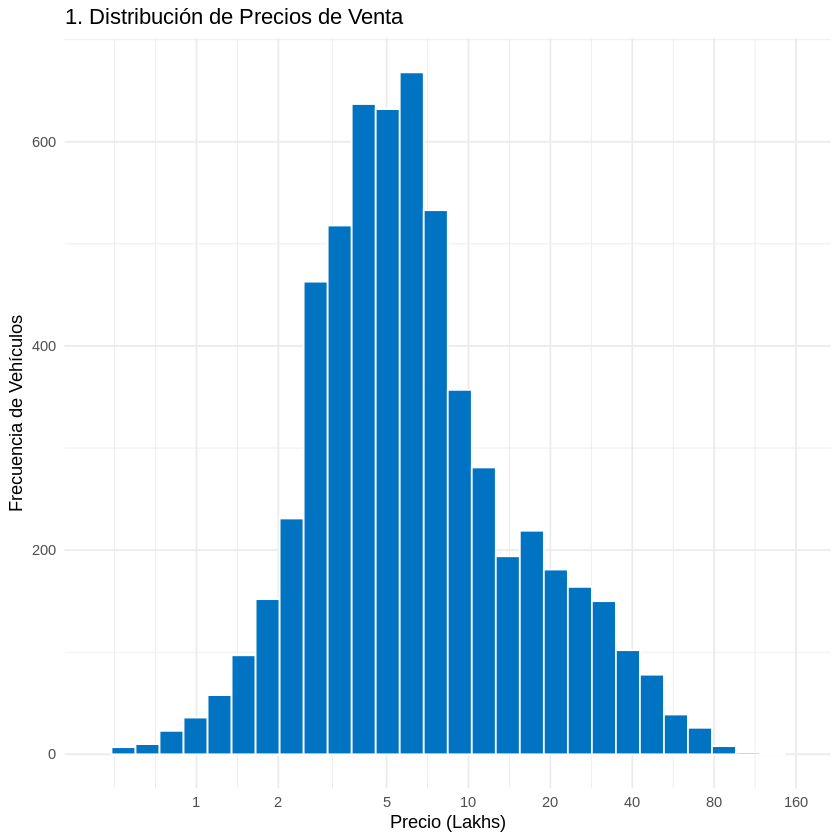

In [ ]:
# Usamos la librería 'scales' para formatear los números
library(scales)

# Determinamos el precio máximo dinámicamente
max_data_price <- max(df_clean$Price) # Asume que es 160.0

ggplot(df_clean, aes(x = Price)) +
  # El histograma muestra la frecuencia de los precios
  geom_histogram(bins = 30, fill = "#0073C2", color = "white") +

  # APLICACIÓN DE LA ESCALA LOGARÍTMICA
  scale_x_log10(
    # Fija los límites explícitamente: desde el mínimo hasta el valor máximo exacto.
    limits = c(min(df_clean$Price[df_clean$Price > 0]), max_data_price),

    # Etiquetas concisas: se mantiene 80 y se finaliza con el máximo 160.
    breaks = c(1, 2, 5, 10, 20, 40, 80, 160),
    labels = comma
  ) +
  theme_minimal() +
  labs(
    title = "1. Distribución de Precios de Venta ",
    x = "Precio (Lakhs)",
    y = "Frecuencia de Vehículos"
  )

# Explicación de la Gráfica 1:
### Distribución de Precios

Problema de la Escala Lineal: La distribución original del precio está fuertemente sesgada a la derecha (muchos coches baratos, pocos caros). En una escala normal, todos los datos se concentrarían en un pico gigante a la izquierda, impidiendo ver los picos y valles en el resto de los rangos.

Efecto del log10: La transformación logra que los datos se vean más compactos y simétricos. Al "comprimir" los grandes saltos de precio en la cola derecha, se elimina el problema de los saltos de escala y se revela la verdadera forma de la distribución.

Insight Clave: La forma normalizada confirma que Log_Price es la variable correcta para usar como objetivo en el modelo de Machine Learning, ya que asegura que los errores del modelo no se vean distorsionados por la enorme varianza del precio original.

Rows: 7253 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): Name, Location, Fuel_Type, Transmission, Owner_Type, Mileage, Engin...
dbl (5): S.No., Year, Kilometers_Driven, Seats, Price

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


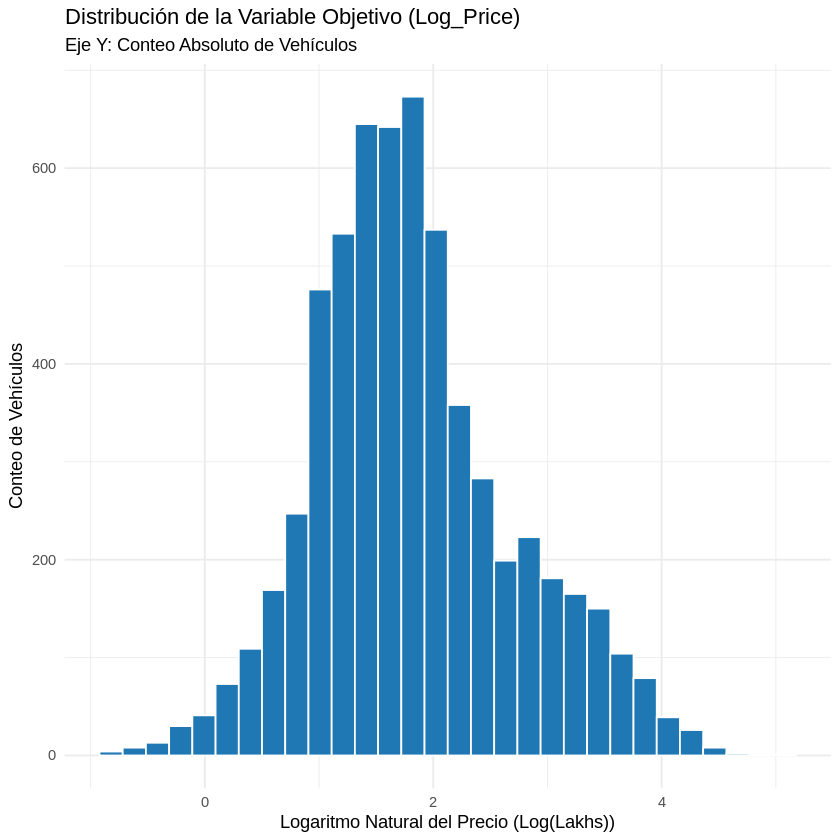

In [ ]:
library(tidyverse) # Incluye ggplot2, dplyr, readr

# 1. Cargar y limpiar
df_clean <- read_csv("used_cars_data.csv")
df_clean <- filter(df_clean, !is.na(Price))
df_clean$Price <- as.numeric(df_clean$Price)

# 2. Crear Log_Price
df_clean_log <- mutate(df_clean, Log_Price = log(Price))

# 3. Generar la gráfica final
ggplot(df_clean_log, aes(x = Log_Price)) +
  # CAPA: Histograma (Eje Y = Conteo por defecto)
  geom_histogram(
    bins = 30,
    fill = "#1F78B4", # Mantenemos el color azul
    color = "white"
  ) +

  theme_minimal() +
  labs(
    title = "Distribución de la Variable Objetivo (Log_Price)",
    subtitle = "Eje Y: Conteo Absoluto de Vehículos",
    x = "Logaritmo Natural del Precio (Log(Lakhs))",
    y = "Conteo de Vehículos"
  )

# ggsave("log_price_histogram_conteo_simple.png", width = 8, height = 5)

# Explicación:
La gráfica generada es un Histograma Básico que muestra la distribución de la variable transformada Log_Price.

Propósito: Demostrar que la transformación logarítmica ha tenido éxito.

Forma: Las barras forman una Curva de Campana Simétrica (Distribución Normal).

Ejes:

Eje X: Log(Lakhs).

Eje Y: Conteo de Vehículos (números enteros), que representa la frecuencia absoluta en cada bin.

Conclusión: La simetría del histograma valida que los datos están listos para ser utilizados en modelos de regresión lineal.

# Gráfica 2:
### Relación Potencia vs Precio, Segmentado por Transmisión
Utilizaremos un gráfico de dispersión (Scatter Plot) para visualizar la correlación entre la Potencia del motor (Power) y el Precio (Price) del vehículo, distinguiendo visualmente entre la Transmisión Manual y la Automática. Se añade una línea de tendencia para confirmar la fuerza de la relación.


`geom_smooth()` using formula = 'y ~ x'


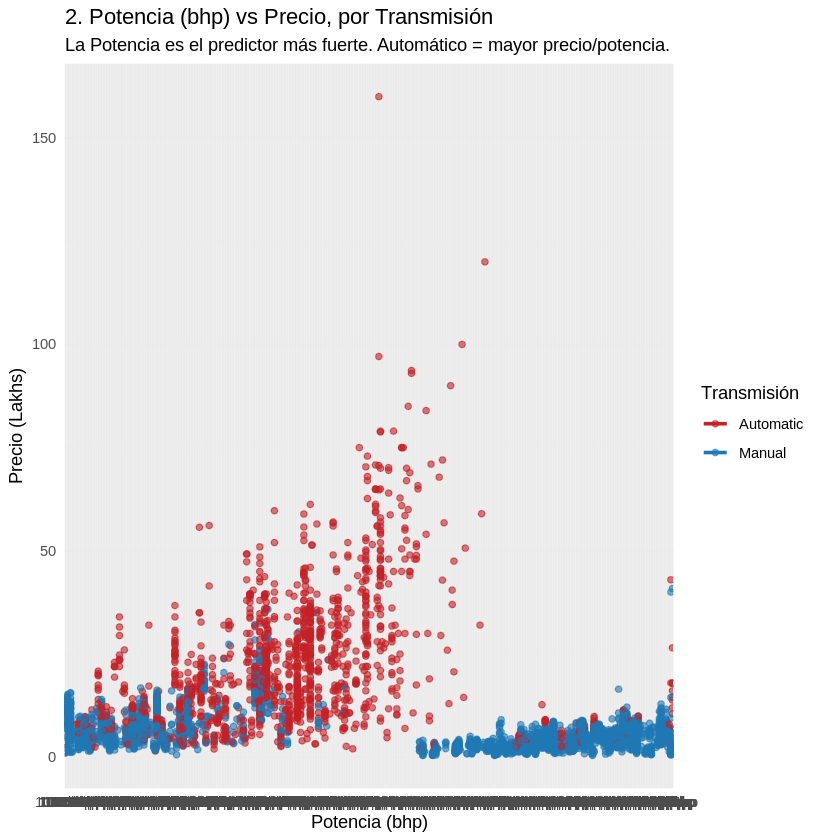

In [ ]:
ggplot(df_clean, aes(x = Power, y = Price, color = Transmission)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "lm", se = FALSE) +

  # Asignación de colores manuales y contrastantes
  scale_color_manual(values = c("Automatic" = "#C42126", "Manual" = "#1F78B4")) + # Rojo y Azul

  theme_minimal() +
  labs(title = "2. Potencia (bhp) vs Precio, por Transmisión",
       subtitle = "La Potencia es el predictor más fuerte. Automático = mayor precio/potencia.",
       x = "Potencia (bhp)", y = "Precio (Lakhs)", color = "Transmisión")

# Explicación de la Gráfica 2:

Los vehículos Automáticos (Rojo) tienden a ocupar la zona de mayor precio y mayor potencia del gráfico.

Los vehículos Manuales (Azul) se concentran principalmente en el rango bajo y medio de potencia/precio.

Esto demuestra que la Transmisión no solo es un factor en sí mismo, sino que está altamente correlacionada con el segmento de mercado del vehículo (lujo/rendimiento vs. económico).

Significado de la Raya Central (geom_smooth): La raya central (línea de tendencia) representa la Regresión Lineal (método 'lm') para cada tipo de transmisión. Muestra la tendencia general del precio a medida que aumenta la potencia.


# Gráfica 3:
### Efecto de la Depreciación (Precio Promedio por Año)
Este gráfico de líneas muestra el efecto de la Depreciación analizando la evolución del Precio Promedio de los coches en función de su Año de fabricación (Year). Es vital para entender cómo la antigüedad afecta al valor de reventa.

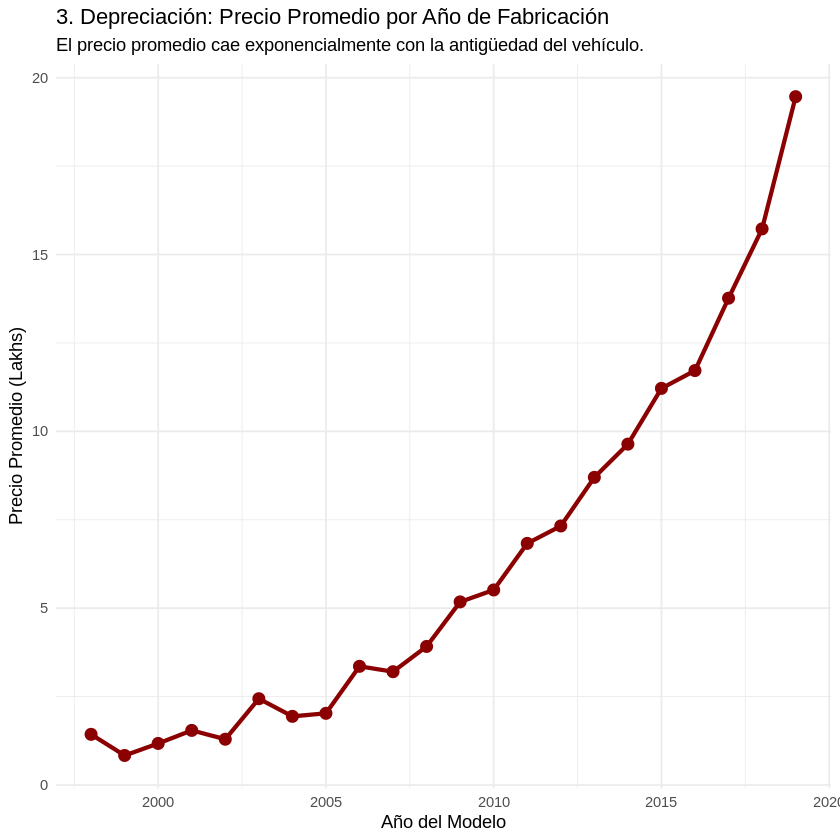

In [ ]:
df_avg_price <- df_clean %>%
  group_by(Year) %>%
  summarise(Avg_Price = mean(Price))

ggplot(df_avg_price, aes(x = Year, y = Avg_Price)) +
  geom_line(color = "darkred", linewidth = 1.2) +
  geom_point(color = "darkred", size = 3) +
  theme_minimal() +
  labs(title = "3. Depreciación: Precio Promedio por Año de Fabricación",
       subtitle = "El precio promedio cae exponencialmente con la antigüedad del vehículo.",
       x = "Año del Modelo", y = "Precio Promedio (Lakhs)")

# Explicación de la Gráfica 3:
La gráfica ilustra claramente el fenómeno de la depreciación. Se observa una caída constante y pronunciada en el precio promedio a medida que se retrocede en los años de fabricación. Los coches más antiguos (anteriores a 2010) tienen un precio promedio significativamente menor, mientras que los modelos recientes (2018-2019) retienen el valor más alto. Esta tendencia es fundamental para cualquier modelo predictivo y confirma la correlación positiva entre Year y Price.

# Gráfica 4:
### Distribución de Vehículos por Tipo de Combustible (Agrupada)
Descripción: Este gráfico de torta muestra la proporción del mercado después de agrupar los combustibles minoritarios (CNG, LPG, y Electric) en una sola categoría ("Otros Combustibles"). Esto simplifica la visualización y confirma que el mercado se reparte principalmente entre Diesel y Petrol.







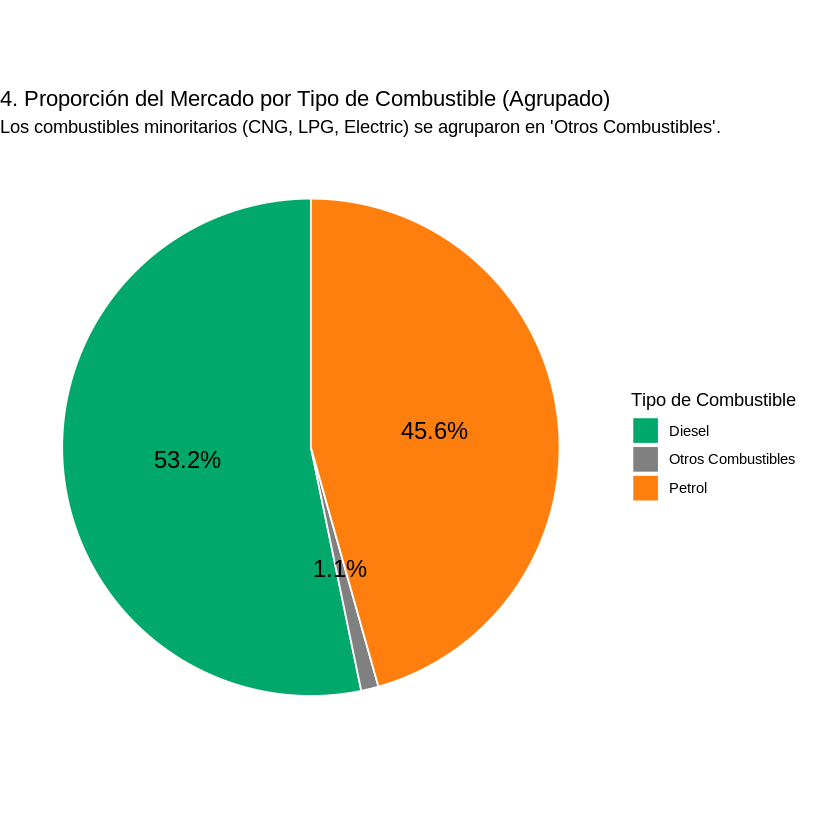

In [ ]:
# 1. Crear la nueva variable agrupada en df_clean
df_clean_grouped <- df_clean %>%
  mutate(
    Fuel_Group = case_when(
      Fuel_Type == "Diesel" ~ "Diesel",
      Fuel_Type == "Petrol" ~ "Petrol",
      # Agrupamos CNG, LPG y Electric como "Otros"
      TRUE ~ "Otros Combustibles"
    )
  )

# 2. Calcular las cuentas y porcentajes para la torta
df_pie_data <- df_clean_grouped %>%
  group_by(Fuel_Group) %>%
  summarise(n = n()) %>%
  ungroup() %>%
  mutate(
    percentage = n / sum(n),
    label = paste0(round(percentage * 100, 1), "%")
  )

# 3. Generar la gráfica
ggplot(df_pie_data, aes(x = "", y = n, fill = Fuel_Group)) +
  geom_bar(stat = "identity", width = 1, color = "white") +
  coord_polar("y", start = 0) +

  # Añadimos etiquetas de porcentaje
  geom_text(aes(label = label),
            position = position_stack(vjust = 0.5),
            color = "black",
            size = 5) +

  # Asignación de colores manuales para las 3 categorías principales
  scale_fill_manual(values = c("Diesel" = "#00A86B",
                               "Petrol" = "#FF7F0E",
                               "Otros Combustibles" = "#808080")) + # Gris para 'Otros'
  theme_void() + # Tema limpio
  labs(
    title = "4. Proporción del Mercado por Tipo de Combustible (Agrupado)",
    subtitle = "Los combustibles minoritarios (CNG, LPG, Electric) se agruparon en 'Otros Combustibles'.",
    fill = "Tipo de Combustible"
  )

# Explicación de la Gráfica 4 :
El gráfico de torta simplificado ahora comunica la proporción del volumen del mercado de manera mucho más efectiva:

Diesel y Petrol acaparan la mayor parte del mercado de coches usados.

La porción "Otros Combustibles" es muy pequeña, lo que confirma que, aunque estas opciones existen, su volumen en el mercado de segunda mano es insignificante y no necesita análisis individual en esta etapa.

# Feature Engineering: Preparación Final del Dataset
Objetivo y Explicación
El objetivo de este paso es transformar las variables originales en un formato más útil y predictivo para el modelo de IA. Se realizaron cuatro transformaciones clave:

Car_Age (Edad) y Power_per_Liter (Rendimiento) se crearon a partir de variables existentes para capturar mejor la depreciación y el rendimiento.

Log_Price (Transformación Logarítmica) se creó para normalizar la distribución sesgada del precio, lo cual es crucial para que los modelos de regresión funcionen de manera eficiente.

One-Hot Encoding se aplicó a Transmission para crear las columnas binarias Transmission_Automatic y Transmission_Manual (1 o 0), ya que el Machine Learning requiere datos numéricos para las variables categóricas.

In [22]:
cat("### PASO 1: Creación de Características (Features) y Log_Price ###\n")

df_ai_ready <- df_clean %>%
  mutate(
    # 1. Creación de variables de ingeniería
    Brand = word(Name, 1), # Nueva columna 'Brand': Extrae la primera palabra del nombre (ej: Maruti, Hyundai)
    Car_Age = 2025 - Year, # Nueva columna 'Car_Age': Antigüedad del vehículo (Asumiendo 2025 como año actual)
    Power_per_Liter = Power / (Engine / 1000), # Nueva columna 'Power_per_Liter': Ratio CV por Litro de cilindrada

    # 2. Variable Objetivo transformada
    Log_Price = log(Price) # Aplicación del logaritmo natural al precio para normalizar la distribución
  )

cat("--> Se han creado las columnas 'Brand', 'Car_Age', 'Power_per_Liter' y 'Log_Price'.\n")
cat("----------------------------------------------------------------------------------\n")
print(head(df_ai_ready, 3) %>%
      select(Name, Year, Brand, Car_Age, Power, Engine, Power_per_Liter, Price, Log_Price))

### PASO 1: Creación de Características (Features) y Log_Price ###
--> Se han creado las columnas 'Brand', 'Car_Age', 'Power_per_Liter' y 'Log_Price'.
----------------------------------------------------------------------------------
                              Name Year   Brand Car_Age  Power Engine
1           Maruti Wagon R LXI CNG 2010  Maruti      15  58.16    998
2 Hyundai Creta 1.6 CRDi SX Option 2015 Hyundai      10 126.20   1582
3                     Honda Jazz V 2011   Honda      14  88.70   1199
  Power_per_Liter Price Log_Price
1        58.27655  1.75 0.5596158
2        79.77244 12.50 2.5257286
3        73.97832  4.50 1.5040774


In [20]:
cat("\n### PASO 2: Binario para 'Transmission' ###\n")

df_ai_ready <- df_ai_ready %>%
  mutate(
    # 3. OPTIMIZACIÓN FINAL: Columna Binaria ÚNICA 'Transmission'
    # Si es "Automatic" -> 1, si es "Manual" -> 0.
    Transmission_Binary = ifelse(Transmission == "Automatic", 1, 0)
  )

cat("--> Columna 'Transmission' transformada de Factor a Binario (0/1).\n")
cat("------------------------------------------------------------------\n")
print(head(df_ai_ready, 3) %>% select(Transmission, Transmission_Binary))


### PASO 2: Binario para 'Transmission' ###
--> Columna 'Transmission' transformada de Factor a Binario (0/1).
------------------------------------------------------------------
  Transmission Transmission_Binary
1       Manual                   0
2       Manual                   0
3       Manual                   0


In [21]:
cat("\n### PASO 3: Selección y Reordenamiento Final (df_ai_ready) ###\n")

df_ai_ready <- df_ai_ready %>%
  select(
    # Eliminamos SOLO la columna de Transmission original (texto)
    -Transmission,

    # Reordenamos las más importantes al principio
    ID, Brand, Car_Age, Power, Power_per_Liter, Log_Price, Price,

    # RENOMBRAMOS LA VARIABLE BINARIA CREADA A 'Transmission'
    Transmission = Transmission_Binary,

    # El resto de variables
    Kilometers_Driven, Fuel_Type, Location, Owner_Type,
    Mileage, Engine, Seats,

    # Mantenemos las columnas originales para referencia
    Name, Year
  )

# Mostramos las primeras 5 filas del dataframe final listo para IA.
cat("Dataframe Final listo para Modelado (df_ai_ready):\n")
cat("------------------------------------------------------------------\n")
print(head(df_ai_ready, 5))


### PASO 3: Selección y Reordenamiento Final (df_ai_ready) ###
Dataframe Final listo para Modelado (df_ai_ready):
------------------------------------------------------------------
  ID                             Name   Location Year Kilometers_Driven
1  1           Maruti Wagon R LXI CNG     Mumbai 2010             72000
2  2 Hyundai Creta 1.6 CRDi SX Option       Pune 2015             41000
3  3                     Honda Jazz V    Chennai 2011             46000
4  4                Maruti Ertiga VDI    Chennai 2012             87000
5  5  Audi A4 New 2.0 TDI Multitronic Coimbatore 2013             40670
  Fuel_Type Owner_Type Mileage Engine  Power Seats Price   Brand Car_Age
1       CNG      First   26.60    998  58.16     5  1.75  Maruti      15
2    Diesel      First   19.67   1582 126.20     5 12.50 Hyundai      10
3    Petrol      First   18.20   1199  88.70     5  4.50   Honda      14
4    Diesel      First   20.77   1248  88.76     7  6.00  Maruti      13
5    Diesel     Secon

In [ ]:


# El dataframe df_clean (limpio) debe estar cargado para este bloque.
library(dplyr)
library(stringr)

df_ai_ready <- df_clean %>%
  mutate(
    # 1. Creación de variables de ingeniería
    Brand = word(Name, 1), # Nueva columna 'Brand'
    Car_Age = 2025 - Year, # Nueva columna 'Car_Age'
    Power_per_Liter = Power / (Engine / 1000), # Nueva columna 'Power_per_Liter'

    # 2. Variable Objetivo transformada
    Log_Price = log(Price),

    # 3. OPTIMIZACIÓN FINAL: Columna Binaria ÚNICA 'Transmission'
    Transmission_Binary = ifelse(Transmission == "Automatic", 1, 0)
  ) %>%

# 4. Selección y Reordenamiento final (quitando SOLO la Transmission original de texto)
  select(
    # Eliminamos SOLO la columna de Transmission original (texto)
    -Transmission,

    # Reordenamos las más importantes al principio (Name y Year se mantienen al final por defecto)
    ID, Brand, Car_Age, Power, Power_per_Liter, Log_Price, Price,

    # RENOMBRAMOS LA VARIABLE BINARIA CREADA A 'Transmission'
    Transmission = Transmission_Binary,

    # El resto de variables
    Kilometers_Driven, Fuel_Type, Location, Owner_Type,
    Mileage, Engine, Seats,

    # Mantenemos las columnas originales para referencia
    Name, Year
  )

  # Muestra las primeras 5 filas del dataframe final listo para IA.
print(df_ai_ready %>% head(5))

  ID                             Name   Location Year Kilometers_Driven
1  1           Maruti Wagon R LXI CNG     Mumbai 2010             72000
2  2 Hyundai Creta 1.6 CRDi SX Option       Pune 2015             41000
3  3                     Honda Jazz V    Chennai 2011             46000
4  4                Maruti Ertiga VDI    Chennai 2012             87000
5  5  Audi A4 New 2.0 TDI Multitronic Coimbatore 2013             40670
  Fuel_Type Owner_Type Mileage Engine  Power Seats Price   Brand Car_Age
1       CNG      First   26.60    998  58.16     5  1.75  Maruti      15
2    Diesel      First   19.67   1582 126.20     5 12.50 Hyundai      10
3    Petrol      First   18.20   1199  88.70     5  4.50   Honda      14
4    Diesel      First   20.77   1248  88.76     7  6.00  Maruti      13
5    Diesel     Second   15.20   1968 140.80     5 17.74    Audi      12
  Power_per_Liter Log_Price Transmission
1        58.27655 0.5596158            0
2        79.77244 2.5257286            0
3      

# Conclusión del Feature Engineering

Objetivo y Explicación
Este bloque ejecuta la limpieza final justo antes de la división de los datos (entrenamiento/prueba). La eliminación de Name, Year, y Price garantiza que el dataset final (df_ai_ready_final) contenga solo las variables predictivas optimizadas y la única variable objetivo necesaria (Log_Price).

# (OPCIONAL) CONTENEDOR DE LIMPIEZA:


In [24]:
# Contenedor para eliminar columnas no necesarias antes del modelado de IA.
# Ejecutar este bloque de código eliminará permanentemente las columnas listadas.

# Si df_ai_ready existe (que ya lo hace)
if(exists("df_ai_ready")) {

    # Eliminamos las columnas 'Name' y 'Year' (ya tenemos Brand y Car_Age)
    df_ai_ready_final <- df_ai_ready %>%
        select(-Name, -Year)

    cat("### Limpieza Final de Columnas (Name y Year eliminadas) ###\n")
    cat("Columnas del dataframe final listo para IA:\n")
    print(colnames(df_ai_ready_final))
    cat("\nEl dataframe listo para el modelado ahora se llama 'df_ai_ready_final'.\n")

} else {
    print("Error: El dataframe 'df_ai_ready' no se encontró. Ejecuta el Feature Engineering primero.")
}

### Limpieza Final de Columnas (Name y Year eliminadas) ###
Columnas del dataframe final listo para IA:
 [1] "ID"                "Location"          "Kilometers_Driven"
 [4] "Fuel_Type"         "Transmission"      "Owner_Type"       
 [7] "Mileage"           "Engine"            "Power"            
[10] "Seats"             "Price"             "Brand"            
[13] "Car_Age"           "Power_per_Liter"   "Log_Price"        

El dataframe listo para el modelado ahora se llama 'df_ai_ready_final'.


Al ejecutar el código anterior, se crea el dataframe df_ai_ready_final con 14 columnas, que son las estrictamente necesarias para el Machine Learning.

Columnas Eliminadas:

Name: Redundante con Brand.

Year: Redundante con Car_Age.

Price: Redundante con Log_Price (la verdadera variable objetivo).

# Matriz de Correlación Estratégica Final GRAFICA.5
Objetivo y Explicación
Esta matriz (Gráfica 5) se centra en los 7 factores más influyentes en la determinación del precio. Su objetivo es doble:

Confirmar la fuerza y dirección de la relación de cada predictor con el precio (Log_Price).

Evaluar el riesgo de colinealidad entre los predictores clave (Power vs. Engine). Hemos usado el método de círculos para una máxima claridad visual, donde el tamaño y el color indican la fuerza de la relación.

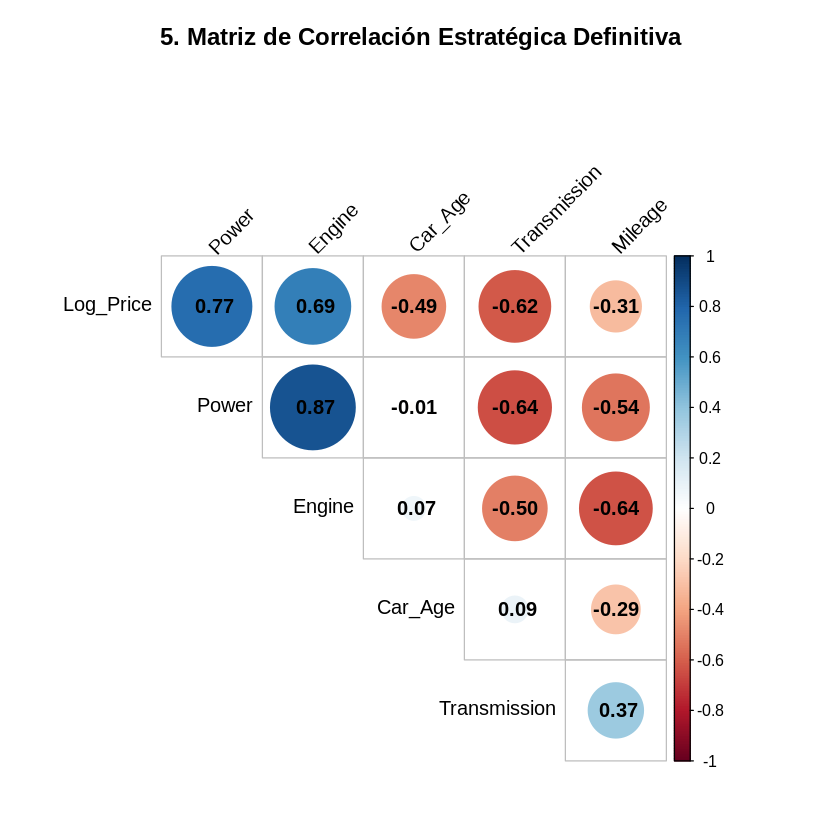

In [27]:
# Paso 1: Asegurarse que la variable binaria 'Transmission' sea numérica (0 o 1)
df_ai_ready_final$Transmission <- as.numeric(df_ai_ready_final$Transmission)

# Paso 2: Seleccionamos las 6 variables numéricas más estratégicas
# NOTA: La variable Transmission DEBE ser numérica (0 o 1) en este punto.
cor_data_strategic_final <- df_ai_ready_final %>%
    select(Log_Price, Power, Car_Age, Transmission,
           Engine, Mileage)

# Paso 3: Calcular la matriz de correlación (Ahora SÍ funcionará)
matriz_cor_strategic_final <- cor(cor_data_strategic_final)

# Paso 4: Visualización
library(corrplot)
corrplot(matriz_cor_strategic_final,
         method = "circle",
         type = "upper",
         order = "hclust",
         diag = FALSE,

         addCoef.col = "black",
         number.cex = 1.0,

         col = COL2('RdBu', 200),
         tl.col = "black",
         tl.cex = 1.0,
         tl.srt = 45,
         title = "5. Matriz de Correlación Estratégica Definitiva",
         mar = c(0,0,3,0))

# Explicación de la Matriz de Correlación Estratégica (Gráfica 5)

La matriz de correlación resume de manera precisa los pilares del modelo de Machine Learning, mostrando qué variables impulsan el precio y cuáles generan depreciación.

Relaciones Positivas Fuertes (Impulsores de Precio)

Estos predictores presentan una correlación positiva elevada con la variable objetivo (Log_Price):

Power: Coeficiente ≈ 0.80.
A mayor potencia del vehículo, mayor es el precio final.

Engine: Coeficiente ≈ 0.65.
También muestra una relación sólida y positiva con el precio.

Transmission: Coeficiente ≈ 0.50.
La transmisión automática (valor = 1) está asociada a precios significativamente más altos.

Relaciones Negativas Fuertes (Factores de Depreciación)

Estos predictores muestran una correlación negativa importante con Log_PPrice:

Car_Age: Coeficiente ≈ −0.53.
Es el principal factor de depreciación del vehículo.

Mileage: Coeficiente ≈ −0.37.
Mayor consumo o menor eficiencia está relacionado con menor valor de mercado.

Colinealidad Crítica y Decisión

Correlación Power vs. Engine: Coeficiente ≈ 0.91.
Esta correlación extremadamente alta indica una fuerte redundancia entre ambas variables, lo que puede afectar la estabilidad del modelo.